In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [4]:
# Create port connections dictionary
port_connections = {}
for i in range(len(pre_df)):
  current_port = pre_df.loc[i, 'place.placeName']
  if i < len(pre_df) - 1:  # Check if next row exists
    next_port = pre_df.loc[i + 1, 'place.placeName']
    if current_port != next_port:  # Avoid self-loops
      if current_port not in port_connections:
        port_connections[current_port] = []
      port_connections[current_port].append(next_port)

# Create directed graph
G = nx.DiGraph()

# Add nodes (ports)
G.add_nodes_from(port_connections.keys())

# Add edges (connections between ports)
for port, connected_ports in port_connections.items():
  for connected_port in connected_ports:
    G.add_edge(port, connected_port)

pos = nx.kamada_kawai_layout(G)

In [5]:
arr = []
for port, connected_ports in port_connections.items():
    arr.append(len(connected_ports))
npArr = np.array(arr)
s = pd.Series(npArr)
print(s.describe())
print(s.quantile(.99))

count    1769.000000
mean       92.784624
std       333.096868
min         1.000000
25%         3.000000
50%        10.000000
75%        52.000000
max      8107.000000
dtype: float64
1449.1599999999992


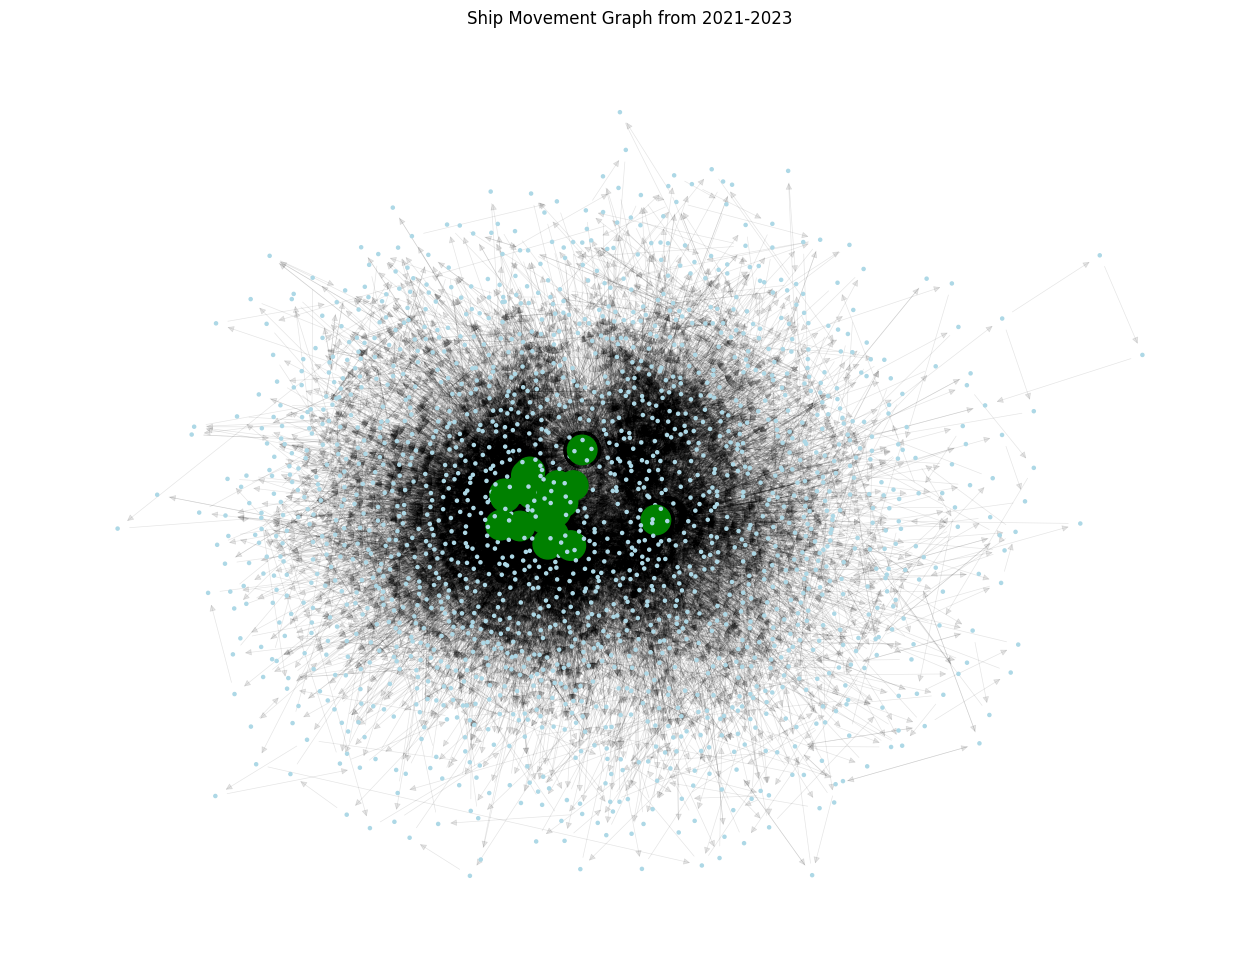

In [7]:
# Assuming G and pos are already defined
plt.figure(figsize=(16, 12))
node_colors = ['green' if len(port_connections[port]) > 1440 else 'lightblue' for port in G.nodes()]
node_sizes = [450 if len(port_connections[port]) > 1440 else 5 for port in G.nodes()]
labels = {node: node if len(port_connections[node]) > 1440 else '' for node in G.nodes()}

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)

# Custom labels with background for better visibility
for node, (x, y) in pos.items():
    if node in labels and labels[node] != '':
        plt.text(x, y, node, fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title("Ship Movement Graph from 2021-2023")
plt.axis('off')  # Hide axes
plt.show()


In [5]:
# preprocess dataframe - duration and month
pre_df["arrivalDate"] = pd.to_datetime(pre_df["arrivalDate"])
pre_df["sailingDate"] = pd.to_datetime(pre_df["sailingDate"])
pre_df["duration"] = pd.to_datetime(pre_df["sailingDate"]) - pd.to_datetime(pre_df["arrivalDate"])
pre_df["month"] = pre_df["arrivalDate"].dt.month

In [6]:
pre_df['duration'] = pre_df['duration'] / pd.Timedelta(days=1)

In [7]:
# drop null values in df
pre_df.dropna(inplace=True)

In [10]:
# preprocess data
# sort by imo number
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_place'] = pre_df.groupby('IMO')['place.placeName'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
pre_df = pre_df[~pre_df["is_last_imo"]]
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

In [11]:
pre_df.columns

Index(['arrivalDate', 'sailingDate', 'place.placeName', 'place.unlocode',
       'place.placeType', 'place.countryName', 'Timestamp', 'Event_Type',
       'IMO', 'vessel.vesselName', 'vessel.vesselType', 'duration', 'month',
       'next_place', 'is_last_imo'],
      dtype='object')

In [ ]:
pre_df

In [ ]:
pre_df = pre_df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])
pre_df

In [ ]:
pre_df = pre_df.drop(columns=["place.unlocode"])
df = pre_df.rename(columns={'place.placeName':'placeName','vessel.vesselType':'vesselType', 'place.placeType': 'placeType', 'place.countryName': 'countryName'})
df

In [16]:
# data statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169291 entries, 314761 to 12575
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   placeName    169291 non-null  object 
 1   placeType    169291 non-null  object 
 2   countryName  169291 non-null  object 
 3   vesselType   169291 non-null  object 
 4   duration     169291 non-null  float64
 5   month        169291 non-null  int32  
 6   next_place   169291 non-null  object 
dtypes: float64(1), int32(1), object(5)
memory usage: 9.7+ MB


In [17]:
pre_df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,169291.0,1.555510,2.895819,0.000012,0.5861,1.019525,1.71798,283.931273
month,169291.0,6.034001,3.271298,1.000000,3.0000,6.000000,9.00000,12.000000


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode categorical features
label_encoders = {}
for column in ['placeType', 'placeName', 'countryName', 'vesselType']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Encode the target variable (port name)
le_target = LabelEncoder()
df['portName_encoded'] = le_target.fit_transform(df['next_place'].astype(str))

In [19]:
# Prepare features and target variable
X = df.drop(['next_place','portName_encoded'], axis=1)
y = df['portName_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


selector = SelectKBest(f_classif, k=4)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)
 
model = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, random_state=42)

model.fit(X_train_reduced, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=50, random_state=42)

In [26]:
# Predict on the test set
y_pred = model.predict(X_test_reduced)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Example of decoding predictions back to port names
predicted_port_names = le_target.inverse_transform(y_pred)
print(predicted_port_names[:10])  # Display the first 10 predictions

Accuracy: 25.73%
['Yokohama' 'Kingstown' 'Semarang' 'Sitrah' 'Yokohama' 'Hamburg'
 'Esmeraldas' 'Pyeongtaek' 'Yeosu' 'Yangshan']


In [ ]:
# use gridsearch